# BilbyBayeswaveAnalysis.ipynb

Maria Okounkova (mokounkova@flatironinstitute.org)

### Notebook for the analysis of Bilby and Bayeswave runs

### Imports

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import corner
from astropy import constants as const
from math import pi
import pesummary
from pesummary.io import read
import json
from math import sqrt
import os.path
from scipy.optimize import curve_fit
from ipynb.fs.full.Auxiliary import SubtractPeakTime, EllinKm, ComputeOverlap, ComputeMultiDetectorOverlap
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24

# gps start time for this simulation
t_gps = 1126259462.0
t_start = t_gps - 2.0

### Root directory - where the repository lives

In [ ]:
root_dir = "/home/maria.okounkova/BeyondGRAnalysis/"

### Functions for injection values, Bayes factors, evidences, etc

In [5]:
def GetTruthDict(p):
    """ Return a dictionary of truth values for corner plots from the parameters.json file 
        corresponding to the injected parameters, where p is the path to the file """
    TruthDict = {}
    
    f = open(p + '/parameters.json')
    params = json.load(f)
    TruthDict['chirp_mass'] = params['chirp_mass']
    TruthDict['mass_ratio'] = params['mass_ratio']
    TruthDict['mass'] = params['mass']
    TruthDict['total_mass'] = params['mass']
    TruthDict['luminosity_distance'] = params['dist_mpc']
    TruthDict['a_1'] = np.abs(params['a_1'][2]) ## assumes aligned spin for now
    TruthDict['a_2'] = np.abs(params['a_2'][2])
    TruthDict['dec'] = params['dec']
    TruthDict['ra'] = params['ra']
    TruthDict['theta_jn'] = params['theta']
    TruthDict['tilt_1'] = 0.0
    TruthDict['tilt_2'] = np.pi
    TruthDict['phase'] = params['phi']
    TruthDict['psi'] = params['pol'] 
    TruthDict['m_1'] = params['m_1']
    TruthDict['m_2'] = params['m_2']
    TruthDict['chi_eff'] = params['chi_eff']
    TruthDict['chi_p'] = 0.0 ## Since this is a non-precessing run
    f.close()
    return TruthDict

def Ell_SNR_String(ell_string, mass, snr):
    """ For dCS parameters, convert from the string corresponding
        to the dimensionless ell value (like `0p0`) to a value
        in kilometers (like 0.0 [km]) """
    ell = float(ell_string.replace('p', '.'))
    mass_msun = mass * const.M_sun
    phys_ell_km = ell * mass_msun * const.G /(const.c**2) / 1000
    string = "%.f km, " % (phys_ell_km.value) + snr
    return string

def Ell_String(ell_string, mass):
    """ For dCS parameters, convert from the string corresponding
        to the dimensionless ell value (like `0p0`) to a value
        in kilometers (like 0.0 [km]) """
    ell = float(ell_string.replace('p', '.'))
    mass_msun = mass * const.M_sun
    phys_ell_km = ell * mass_msun * const.G /(const.c**2) / 1000
    string = "%.f km" % (phys_ell_km.value)
    return string

def SummaryPageFile(name):
    return root_dir + "BilbyBayeswaveAnalysis/" + name + \
        "/summary_pages/samples/posterior_samples.h5"

def GetBWDir(p):
    return p + '/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/'

def GetBWInjectedData(p, det = "H1"):
    """ Given a BW run directory and a detector, read in the injected time domain waveform """
    
    base_dir = GetBWDir(p)
    
    f = base_dir + 'post/whitened_data_' + det + '.dat'
    data = np.loadtxt(f)
    
    ## Compute the corresponding time array 
    s_rate = 2048
    dt = 1.0/s_rate
    time = np.array([dt * t for t in range(len(data))])
 
    time = time + t_start
    return time, data

def GetBWMedianData(p, det = "H1"):
    """ Given a BW run directory and a detector, read in the median time domain waveform 
        and confidence intervals (90% and 50%)"""
    
    base_dir = GetBWDir(p)

    ## Grab Livingston data
    f = base_dir + "post/signal/signal_median_time_domain_waveform_" + det + ".dat"
    time, d1, d2, d3, d4, d5 = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4,5]),unpack=True)
    
    time = time + t_start
    return time, d1, d2, d3, d4, d5

def GetBWTimes(p, det = "H1"):
    """ Given a BW run directory p and a detector, read in Bayeswave time axis """
    
    base_dir = GetBWDir(p)
    f = base_dir + "post/signal/signal_median_time_domain_waveform_" + det + ".dat"
    time = np.loadtxt(f, comments="#",usecols=([0]),unpack=True)
    time = time + t_start
    return time

def GetBilbyData(p, det = "H1"):
    """ Given a directory p, grab the whitened Bilby waveforms """
    
    bilby_p = p + '/LI_reconstruct/'
    time, MAP, lo, hi = np.loadtxt(bilby_p + det + '_summary_waveforms_samples.dat', \
        comments="#",usecols=([0,2,3,5]),unpack=True)
    return time, MAP, lo, hi

def GetBilbyReconstruction(p, det = 'L1'):
    """ Given a directory p, grap the injected waveforms and the bilby waveforms """

    bi_p = p + '/LI_reconstruct/'
    bw_p = p + '/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/'
    
    h_bw_inj = np.loadtxt(bw_p + 'post/whitened_data_' + det + '.dat')
    t_bw_inj = np.array([1.0/2048 * t for t in range(len(h_bw_inj))])
    t_bw_inj = t_bw_inj + t_start
    
    t_bi, map_bi, lo_bi, hi_bi = \
        np.loadtxt(bi_p + det + '_summary_waveforms_samples.dat', \
        comments="#",usecols=([0,1,3,5]),unpack=True)
    
    return t_bw_inj, h_bw_inj, t_bi, map_bi, lo_bi, hi_bi

def GetBilbyTimes(p, det = 'L1'):
    """ Given a Bilby run directory p and a detector, read in Bayeswave time axis """
    bi_p = p + '/LI_reconstruct/'
    t_bi = np.loadtxt(bi_p + det + '_summary_waveforms_samples.dat', \
        comments="#",usecols=([0]),unpack=True)
    return t_bi

## Dictionary for summary pages quantity name -> latex expression for plotting
params_labels_dict = {'mass_ratio' : r'$q$', 'chi_p' : r'$\chi_p$', 'chi_eff' : r'$\chi_\mathrm{eff}$', 'total_mass' : r'$M [M_\odot]$'}
## Dictionary for parameter ranges for plotting
RangeDict = {'mass_ratio': (0.7, 1.0), 'total_mass' : (65.0, 71.0), 'chi_eff' : (-0.15, 0.15), 'chi_p' : (0.0, 1.0), 'luminosity_distance' : (0, 3000)}


In [6]:
## Grab the mass
p = root_directory +'BilbyBayeswaveAnalysis/dCS_0p0_75'
TruthDict = GetTruthDict(p)
mass = TruthDict['mass']

### One dimensional histograms for Bilby data

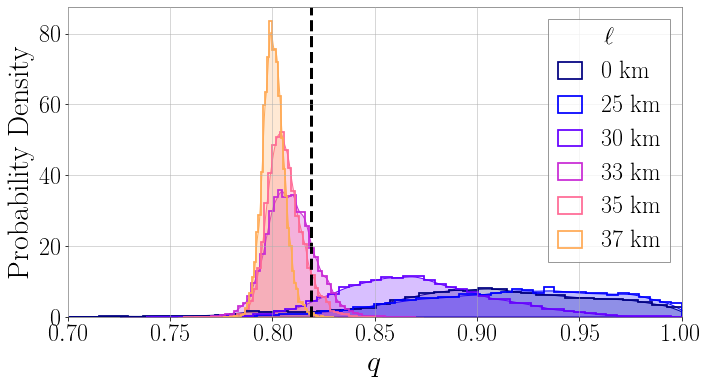

In [7]:
def Histogram(param, snr = '125'):
    
    """ Given a parameter and an snr, produce one-dimensional kde plots
        for the posterior distribution, for a variety of values of ell """

    ells = ['0p0', '0p25', '0p3', '0p33', '0p35', '0p37']
    colors = sns.color_palette('gnuplot2', n_colors=len(ells) + 1)
    
    fig, ax = plt.subplots(1, figsize = (10, 5.5))

    for ell, color in zip(ells, colors):
        
        file_name = SummaryPageFile('dCS_' + ell + '_' + snr)
        data = read(file_name)
        samples_dict = data.samples_dict
        posterior_samples = samples_dict["summary_pages"]
        posterior_samples.plot(param, kde=True, color = color, label = Ell_String(ell, mass), fig = fig, plot_percentile = False, title = False)
        
    plt.xlim(RangeDict[param])
    leg = plt.legend(loc = 'upper right', title = '$\ell$', fontsize = 24)
    plt.setp(leg.get_title(), fontsize = 24)
    plt.grid(True)
    ax.tick_params(axis='both', labelsize=24)
    xlbl = ax.xaxis.get_label()
    ax.set_xlabel(xlbl.get_text(), fontsize=30)
    ylbl = ax.yaxis.get_label()
    ax.set_ylabel(ylbl.get_text(), fontsize=30)
    
    ax.axvline(TruthDict[param], color = 'black', ls = '--', lw = 3.0)
     
    plt.tight_layout()
    plt.savefig('kde_' + param + '_' + snr + '.pdf')
    plt.show()
    
Histogram("mass_ratio", snr = '125')
#Histogram("chi_p", snr = '125')
#Histogram("chi_eff", snr = '125')

### Bilby results corner plot

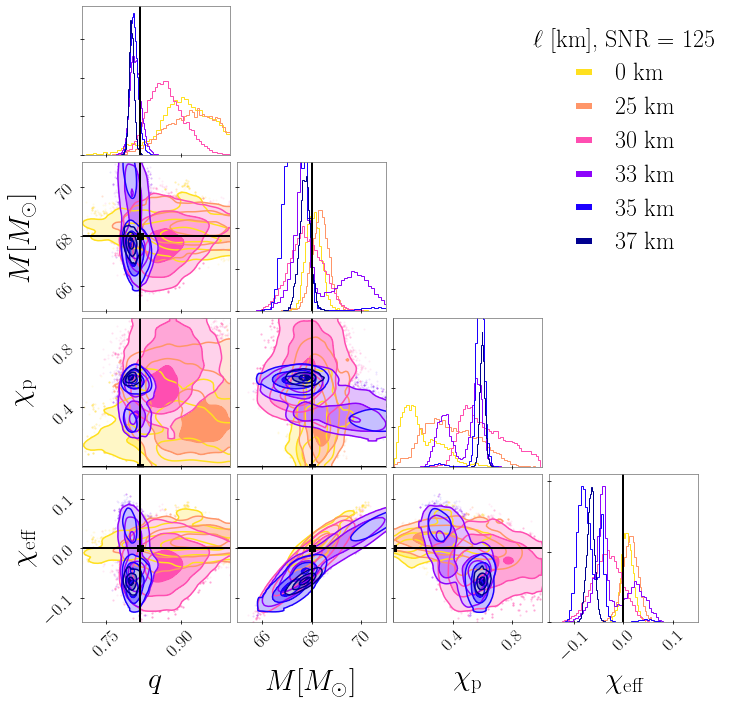

In [9]:
def CornerPlot(SNR):
    """ Make a corner plot of Bilby runs on GR injections with various values of ell, 
        for a given value of SNR"""

    base = root_dir + 'BilbyBayeswaveAnalysis/'
    parameters = ['mass_ratio', 'total_mass', 'chi_p', 'chi_eff']
        
    truths = [TruthDict[param] for param in parameters]
    ranges = [RangeDict[param] for param in parameters]
    dim = len(parameters) 

    ells = ['0p0', '0p25', '0p3', '0p33', '0p35', '0p37']
    colors = sns.color_palette('gnuplot2_r', n_colors=len(ells))

    
    fig, ax_arr = plt.subplots(dim, dim, figsize=(10, 10))
    handles = []
    
    for ell, c in zip(ells, colors):
        
        file_name = SummaryPageFile('dCS_' + ell + '_' + SNR)
        data = read(file_name)
        samples_dict = data.samples_dict
        posterior_samples = samples_dict["summary_pages"]
        posterior_samples.plot(type="corner",
                             parameters=parameters, fig = fig, color = c, truths=truths, truth_color='black', \
                               quantiles=[], range=ranges, kde=True, smooth=1.5)
    
        ## Dealing with the legend
        l = ax_arr[0][dim-1].plot([0,0], [0,0], label=r"%d" % EllinKm(ell, mass) + " km", color = c)
        handles.append(l[0])

        ## Plot the injected values myself
        legend = ax_arr[0][3].legend(handles=handles, frameon=False, title = r'$\ell$ [km], SNR = ' + SNR, loc = 'upper center', fontsize=24)

        for i in range(4):
            ax_arr[i][0].set_xlim(RangeDict['mass_ratio'])
            ax_arr[i][1].set_xlim(RangeDict['total_mass'])
            ax_arr[i][2].set_xlim(RangeDict['chi_p'])
            ax_arr[i][3].set_xlim(RangeDict['chi_eff'])

        ax_arr[1][0].set_ylim(RangeDict['total_mass'])
        
        ax_arr[2][0].set_ylim(RangeDict['chi_p'])
        ax_arr[2][1].set_ylim(RangeDict['chi_p'])
        
        ax_arr[3][0].set_ylim(RangeDict['chi_eff'])
        ax_arr[3][1].set_ylim(RangeDict['chi_eff'])
        ax_arr[3][2].set_ylim(RangeDict['chi_eff'])

        for ax in fig.get_axes():

            ax.tick_params(axis='y', direction='inout', labelsize=18)
            ax.tick_params(axis='x', direction='inout', labelsize=18)

        plt.setp(legend.get_title(),fontsize=24)

        for ax in fig.get_axes():
            ax.grid(False)
            xlbl = ax.xaxis.get_label()
            ax.set_xlabel(xlbl.get_text(), fontsize=30)
            ylbl = ax.yaxis.get_label()
            ax.set_ylabel(ylbl.get_text(), fontsize=30)

    plt.savefig('dCSCorner_' + SNR + '.pdf')
    plt.show()

CornerPlot('125')

### Plot Bilby and Bayeswave reconstruction with residual

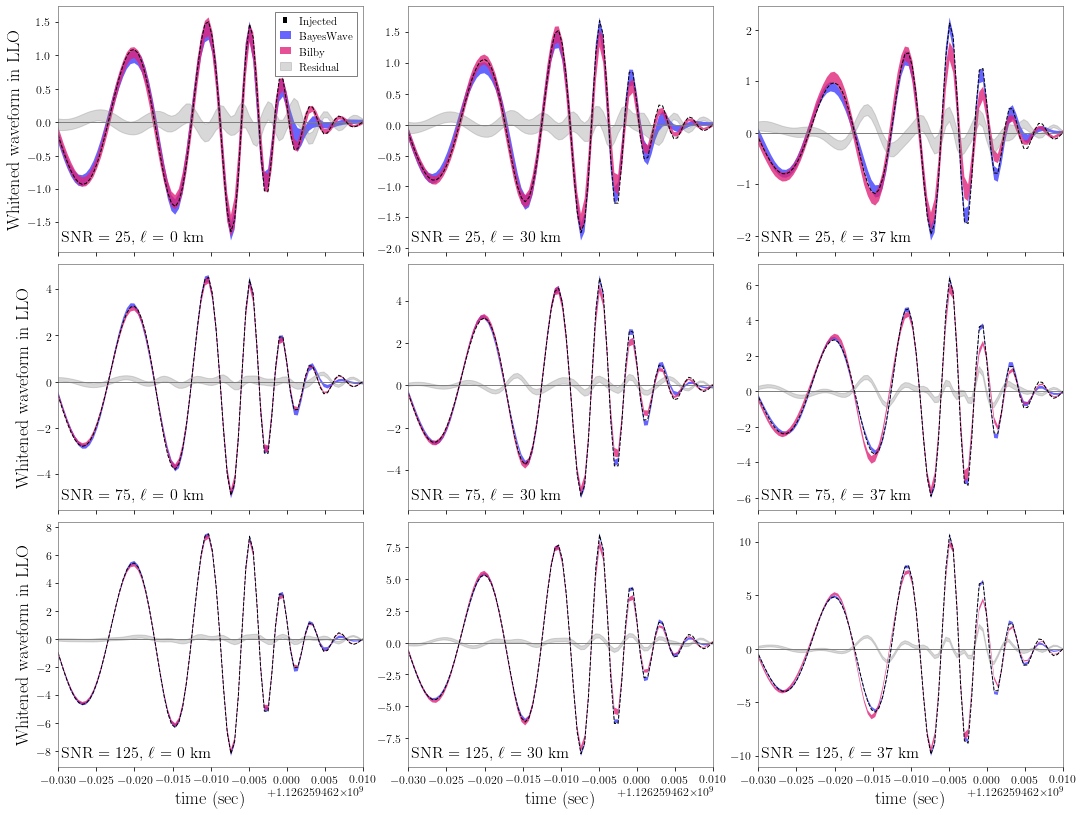

In [17]:
def ComputeResiduals(time_1, h_1, h_1_lo, h_1_hi, time_2, h_2, h_2_lo, h_2_hi):
    """ Given two (time, strain) datasets, compute the residual, between them """
    res_med = h_1 - h_2
    res_lo = h_1_lo - h_2
    res_hi = h_1_hi - h_2
    return time_1, res_med, res_lo, res_hi

def PlotReconstructedData(p, ax, det = "L1", label = "", legend = False):
    """ Given a directory and an axis, plot BW reconstruction, 
        Bilby reconstruction, and the residual """
    
    ## Injected data
    time_inj, data_inj = GetBWInjectedData(p, det = det)
    
    ## Bayeswave data
    time_bw, d1, d2, d3, d4, d5 = GetBWMedianData(p, det = det)
    bw_color = "blue" 
    
    ## Bilby data
    time_bilby, data_bilby, lo_bilby, hi_bilby = GetBilbyData(p, det = det)
    bilby_color = "#e02479" 
    
    ## Plot BW data
    ax.fill_between(time_bw, d2, d3, alpha = 0.6, color=bw_color, edgecolor=None, linewidth=0.0, label = 'BayesWave') ## 90% interval

    # Plot Bilby reconstruction
    ax.fill_between(time_bilby, lo_bilby, hi_bilby, alpha = 0.8, color=bilby_color, linewidth = 0.0, edgecolor=None, label = 'Bilby') ## 90% interval

    ## Compute and plot the residual
    t_res, res, res_lo, res_hi = ComputeResiduals(time_bw, d1, d2, d3, time_bilby, data_bilby, lo_bilby, hi_bilby)
    ax.fill_between(t_res, res_lo, res_hi, color = 'gray', alpha = 0.3, label = 'Residual')
    ax.axhline(0.0, color = 'gray', lw = 1.0)
    
    ## Plot injected data 
    time_inj, data_inj = GetBWInjectedData(p, det = det)
    ax.plot(time_inj, data_inj, '--', color='black', lw = 1.0, alpha=1.0,  label = 'Injected')
    
    ## Label ell and SNR
    ax.text(0.01, 0.06, label, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=16)
    ax.set_xlim(t_gps - 0.03, t_gps + 0.01)
    ax.grid(False)
    
    if legend:
        # get handles and labels
        handles, labels = ax.get_legend_handles_labels()
        # specify order of items in legend
        order = [0, 1, 2, 3]
        # add legend to plot
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=True, framealpha = 1.0, fontsize=11, loc='upper right')
    
def PlotReconstructions(det = "L1"):
    """ Plot BW reconstruction, Bilby reconstruction, and the residual 
         All data is in the time domain and whitened 
    """
        
    det_strings = {"L1":"LLO", "H1":"LHO", "V1":"Virgo"}
    base_dir = root_dir + "BilbyBayeswaveAnalysis/"
    
    fig, axarr = plt.subplots(3,3, figsize=(18, 14), sharex=True, sharey=False, gridspec_kw={'width_ratios': [1, 1, 1]})
    
    ell = "0p0"
    PlotReconstructedData(base_dir + "dCS_" + ell + "_25", axarr[0][0], det = det, \
                  label = r'SNR = 25, $\ell$ = %d km' % EllinKm(ell, mass), legend = True)
    PlotReconstructedData(base_dir + "dCS_" + ell + "_75", axarr[1][0], det = det, \
                   label = r'SNR = 75, $\ell$ = %d km' % EllinKm(ell, mass))
    PlotReconstructedData(base_dir + "dCS_" + ell + "_125", axarr[2][0], det = det, \
                   label = r'SNR = 125, $\ell$ = %d km' % EllinKm(ell, mass))

    ell = "0p3"
    PlotReconstructedData(base_dir + "dCS_" + ell + "_25", axarr[0][1], det = det, \
                   label = r'SNR = 25, $\ell$ = %d km' % EllinKm(ell, mass))
    PlotReconstructedData(base_dir + "dCS_" + ell + "_75", axarr[1][1], det = det, \
                   label = r'SNR = 75, $\ell$ = %d km' % EllinKm(ell, mass))
    PlotReconstructedData(base_dir + "dCS_" + ell + "_125", axarr[2][1], det = det, \
                   label = r'SNR = 125, $\ell$ = %d km' % EllinKm(ell, mass))
    
    ell = "0p37"
    PlotReconstructedData(base_dir + "dCS_" + ell + "_25", axarr[0][2], det = det, \
                    label = r'SNR = 25, $\ell$ = %d km' % EllinKm(ell, mass))
    PlotReconstructedData(base_dir + "dCS_" + ell + "_75", axarr[1][2], det = det, \
                   label = r'SNR = 75, $\ell$ = %d km' % EllinKm(ell, mass))
    PlotReconstructedData(base_dir + "dCS_" + ell + "_125", axarr[2][2], det = det, \
                   label = r'SNR = 125, $\ell$ = %d km' % EllinKm(ell, mass))

    for i in range(3):
        axarr[-1][i].set_xlabel('time (sec)', fontsize = 18)
        
    for i in range(3):
        axarr[i][0].set_ylabel('Whitened waveform in ' + det_strings[det], ha='center', labelpad = 4.0, rotation='vertical', fontsize=18)
    
    plt.subplots_adjust(wspace=0.15, hspace=0.05)
    plt.savefig('Reconstructions.pdf')
    plt.show()

PlotReconstructions(det = "L1")

### Plot Bilby & Injected and Bayeswave & Injected mismatches

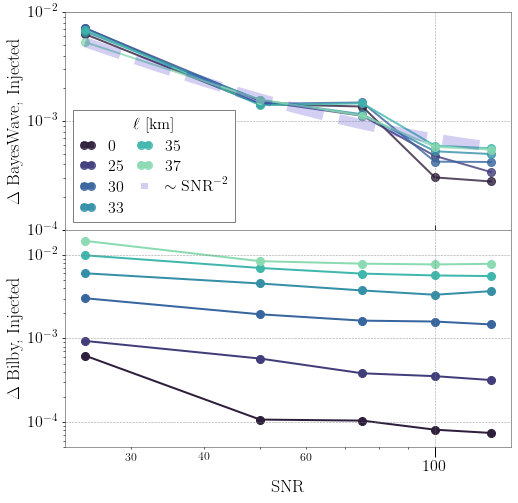

In [19]:
def BilbyOverlap(p):
    """ Given a run directory p, read in the injected and bilbly recovered strains in the 
        time domain and compute an overlap """
    
    base_dir = root_dir + 'BilbyBayeswaveAnalysis/' 
    bi_p = p + '/LI_reconstruct/'
        
    ## Check for file with computed multi-detector bilby overlap 
    name = base_dir + p + "/LI_reconstruct/bilby_overlaps.dat"

    if not os.path.isfile(name):
        
        print("Generating bilby_overlaps.dat file")
    
        t_inj_H1, h_inj_H1, t_bi_H1, h_bi_H1, d, d = GetBilbyReconstruction(p, det = "H1")
        t_inj_L1, h_inj_L1, t_bi_L1, h_bi_L1, d, d = GetBilbyReconstruction(p, det = "L1")
        t_inj_V1, h_inj_V1, t_bi_V1, h_bi_V1, d, d = GetBilbyReconstruction(p, det = "V1")

        overlap_H1 = ComputeOverlap(t_bi_H1, h_bi_H1, t_inj_H1, h_inj_H1)
        overlap_L1 = ComputeOverlap(t_bi_L1, h_bi_L1, t_inj_L1, h_inj_L1)
        overlap_V1 = ComputeOverlap(t_bi_V1, h_bi_V1, t_inj_V1, h_inj_V1)
        
        overlap_all = ComputeMultiDetectorOverlap(t_bi_H1, h_bi_H1, \
                                  t_bi_L1, h_bi_L1, \
                                  t_bi_V1, h_bi_V1, \
                                  t_inj_H1, h_inj_H1, \
                                  t_inj_L1, h_inj_L1, \
                                  t_inj_V1, h_inj_V1)
        
        print('%f %f %f %f' % (overlap_H1, overlap_L1, overlap_V1, overlap_all))
        f_out = open(name, 'w')
        f_out.write('# Overlap between injected and median reconstructed bilby waveforms \n # overlap_H1 overlap_L1 overlap_V1 overlap_all \n')
        f_out.write('%f %f %f %f' % (overlap_H1, overlap_L1, overlap_V1, overlap_all))
        f_out.close()
    
    overlap_H1, overlap_L1, overlap_V1, overlap_all = np.loadtxt(name, comments="#",usecols=([0, 1, 2, 3]),unpack=True)
    return overlap_all

def BayesWaveOverlap(p):
    """ Given a BW run directory p, read in the injected and recovered hs in the 
        time domain and compute an overlap """
    
    ## Check for file with computed multi-detector BW overlap 
    name = GetBWDir(p) + "overlaps.dat"

    if not os.path.isfile(name):
        
        print("Generating overlaps.dat file")
    
        ## Median data and bounds
        t_bw_H1, h_bw_H1, h_bw_2, h_bw_3, h_bw_4, h_bw_5 = GetBWMedianData(p, det = "H1")
        t_bw_L1, h_bw_L1, h_bw_2, h_bw_3, h_bw_4, h_bw_5 = GetBWMedianData(p, det = "L1")
        t_bw_V1, h_bw_V1, h_bw_2, h_bw_3, h_bw_4, h_bw_5 = GetBWMedianData(p, det = "V1")
    
        ## Injected data
        t_inj_H1, h_inj_H1 = GetBWInjectedData(p, det = "H1")
        t_inj_L1, h_inj_L1 = GetBWInjectedData(p, det = "L1")
        t_inj_V1, h_inj_V1 = GetBWInjectedData(p, det = "V1")
    
        overlap_H1 = ComputeOverlap(t_bw_H1, h_bw_H1, t_inj_H1, h_inj_H1)
        overlap_L1 = ComputeOverlap(t_bw_L1, h_bw_L1, t_inj_L1, h_inj_L1)
        overlap_V1 = ComputeOverlap(t_bw_V1, h_bw_V1, t_inj_V1, h_inj_V1)
        
        overlap_all = ComputeMultiDetectorOverlap(t_bw_H1, h_bw_H1, \
                                  t_bw_L1, h_bw_L1, \
                                  t_bw_V1, h_bw_V1, \
                                  t_inj_H1, h_inj_H1, \
                                  t_inj_L1, h_inj_L1, \
                                  t_inj_V1, h_inj_V1)
        
        print('%f %f %f %f' % (overlap_H1, overlap_L1, overlap_V1, overlap_all))
        f_out = open(name, 'w')
        f_out.write('# Overlap between injected and median reconstructed BW waveforms \n # overlap_H1 overlap_L1 overlap_V1 overlap_all \n')
        f_out.write('%f %f %f %f' % (overlap_H1, overlap_L1, overlap_V1, overlap_all))
        f_out.close()
    
    overlap_H1, overlap_L1, overlap_V1, overlap_all = np.loadtxt(name, comments="#",usecols=([0, 1, 2, 3]),unpack=True)
    return overlap_all

def PlotBayesWaveBilbyOverlap():
    """ Create a plot of the overlap between BW injected and recovered waveforms and 
        Bilby injected and recovered waveforms as
        a function of SNR. Similar to Fig. 4 in https://arxiv.org/abs/2003.09456 """
    
    base_dir = root_dir + "BilbyBayeswaveAnalysis/"

    ells = ["0p0", "0p25", "0p3", "0p33", "0p35",  "0p37"]
    colors = sns.color_palette('mako', n_colors=len(ells))
    snrs = [25, 50, 75, 100, 125]

    fig, ax = plt.subplots(2, figsize=(8, 8), sharex = True)
    
    for ell, color in zip(ells, colors):
        
        bilby_delta_arr = []
        bw_delta_arr = []

        for snr in snrs:

            ## Bayeswave overlap
            p = base_dir + "dCS_" + ell + "_" + str(snr)
            overlap = BayesWaveOverlap(p)
            bw_delta = 1.0 - overlap
            bw_delta_arr.append(bw_delta)

            ## Bilby overlap
            p = "dCS_" + ell + "_" + str(snr)
            overlap = BilbyOverlap(p)
            bilby_delta = 1.0 - overlap
            bilby_delta_arr.append(bilby_delta)

        ax[0].plot(snrs, bw_delta_arr, '-o', color = color,  lw = 2.0, alpha = 0.8, label = "%d" % EllinKm(ell, mass), markersize = 8)
        ax[1].plot(snrs, bilby_delta_arr, '-o', color = color, lw = 2.0, label = "$\ell$ = %d km" % EllinKm(ell, mass), markersize = 8)

    ## Add in 1/SNR^2 curve 
    def func(x, a, c):
        return a*x**-2 + c
    
    popt, pcov = curve_fit(func, snrs, bw_delta_arr)
    snrs_plot = np.linspace(snrs[0], snrs[-1], 100)
    ax[0].plot(snrs_plot, func(snrs_plot, *popt), color='#2712c4', label = r'$\sim \mathrm{SNR}^{-2}$', alpha = 0.2, lw = 10.0, ls = '--')

    plt.subplots_adjust(hspace=0.0)
    
    leg = ax[0].legend(fontsize=16, ncol=2, title = r'$\ell$ [km]', \
                       columnspacing=0.8, labelspacing = 0.4, framealpha = 1.0, frameon = True, loc = 'lower left')
    plt.setp(leg.get_title(),fontsize=16)
    
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    ax[0].set_xscale('log')
    ax[1].set_xscale('log')

    ax[0].set_ylabel(r'$\Delta$ BayesWave, Injected', fontsize=18)
    ax[1].set_ylabel(r'$\Delta$ Bilby, Injected', fontsize=18)
    ax[1].set_xlabel('SNR', fontsize=18)
    
    ax[0].tick_params(axis='y', labelsize=16)
    ax[1].tick_params(axis='y', labelsize=16)
      
    ax[0].tick_params(axis = 'x', direction='inout', length=10)
    ax[1].tick_params(axis = 'x', direction='out', length=10, width=1, colors='k',
               grid_color='b', grid_alpha=0.5, labelsize=16)
    
    ax[0].set_ylim(1e-4, 1e-2)
    ax[1].set_ylim(5e-5, 2e-2)
    for axis in ax:
        axis.grid(True, alpha=0.7, lw = 0.6, ls = '--', color = 'gray')
    plt.savefig('Mismatches.pdf') 
    plt.show()
    
PlotBayesWaveBilbyOverlap()

### Plot Bayeswave & Bilby mismatch

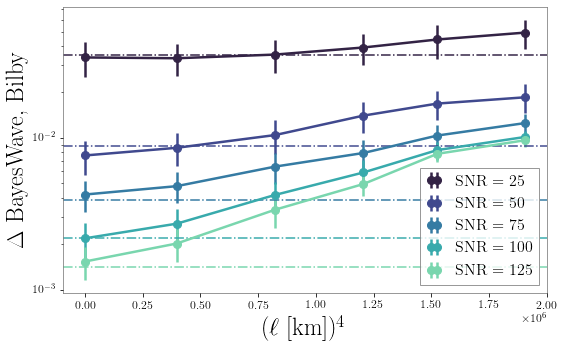

In [39]:
def GetBilbyDraws(p):
    """ Grab reconstructed Bilby waveforms sampled from 
        the posterior """

    ## Get time array
    t_H1 = GetBilbyTimes(p, det = 'H1')
    t_L1 = GetBilbyTimes(p, det = 'L1')
    t_V1 = GetBilbyTimes(p, det = 'V1')
    
    file = p + '/LI_reconstruct/waveforms_samples.npy'
    waveform_samples = np.load(file)
    
    ### We called reclal.py with ifos H1 L1 V1
    H1_samples = waveform_samples[0]
    L1_samples = waveform_samples[1]
    V1_samples = waveform_samples[2]
    
    return t_H1, H1_samples, t_L1, L1_samples, t_V1, V1_samples
    
def GetBayesWaveDraws(p):
    """ Grab reconstructed Bayeswave waveforms sampled from 
        the posterior """
        
    ## Get time array
    t_H1 = GetBWTimes(p, det = 'H1')
    t_L1 = GetBWTimes(p, det = 'L1')
    t_V1 = GetBWTimes(p, det = 'V1')
    
    H1_samples = np.loadtxt(GetBWDir(p) + "post/signal/signal_recovered_whitened_waveform_H1.dat")
    L1_samples = np.loadtxt(GetBWDir(p) + "post/signal/signal_recovered_whitened_waveform_L1.dat")
    V1_samples = np.loadtxt(GetBWDir(p) + "post/signal/signal_recovered_whitened_waveform_V1.dat")

    return t_H1, H1_samples, t_L1, L1_samples, t_V1, V1_samples

def GetBilbyBWMismatch(base_dir):
    """ Compute the mismatch between Bilby and Bayeswave reconstructed waveforms, for
        a set of waveform samples """
    
    name = base_dir + "/LI_reconstruct/mismatch_errorbars.txt"
    if not os.path.isfile(name):
        
        print("Generating " + name)
    
        ## BW recovered data
        t_bw_H1, h_bw_H1, h_bw_2_H1, h_bw_3_H1, h_bw_4, h_bw_5 = GetBWMedianData(base_dir, det = "H1")
        t_bw_L1, h_bw_L1, h_bw_2_L1, h_bw_3_L1, h_bw_4, h_bw_5 = GetBWMedianData(base_dir, det = "L1")
        t_bw_V1, h_bw_V1, h_bw_2_V1, h_bw_3_V1, h_bw_4, h_bw_5 = GetBWMedianData(base_dir, det = "V1")
        
        det = "L1"
        
        ## Bilby Draws
        t_H1, H1_samples, t_L1, L1_samples, t_V1, V1_samples = GetBilbyDraws(base_dir)
        
        ## Bayeswave Draws
        bwt_H1, bwH1_samples, bwt_L1, bwL1_samples, bwt_V1, bwV1_samples = GetBayesWaveDraws(base_dir)
            
        ## For each of the draws, compute an overlap
        N = 200
        mismatches = np.zeros(N)
        for i in range(N):
            overlap = ComputeMultiDetectorOverlap( \
                                  bwt_H1, bwH1_samples[i], \
                                  bwt_L1, bwL1_samples[i], \
                                  bwt_V1, bwV1_samples[i], \
                                  t_H1, H1_samples[i], \
                                  t_L1, L1_samples[i], \
                                  t_V1, V1_samples[i])
            mismatches[i] = 1 - overlap
        np.savetxt(name, mismatches)

    mismatch_arr = np.loadtxt(name)
    return mismatch_arr

def PlotBilbyBWMismatch():
    """ Plot the mismatch between Bilby and Bayeswave reconstructed waveforms, for
        a set of waveform samples """
    base_dir = root_dir + "BilbyBayeswaveAnalysis/"
    
    fig = plt.figure(figsize=(8, 5))
    plt.xlabel(r'($\ell$ [km])${}^4$')
    plt.ylabel('$\Delta$ BayesWave, Bilby')
    plt.yscale('log')
    
    ells = ["0p0", "0p25", "0p3", "0p33", "0p35", "0p37"]
    ells_km = np.array([EllinKm(l, 68) for l in ells])**4
    snrs = ['25', '50', '75', '100', '125']
    colors = sns.color_palette('mako', n_colors=len(snrs))
    
    for snr, color in zip(snrs, colors):
        
        mismatch_meds = []
        mismatch_errors = []
        
        for ell in ells:
            
            p = base_dir + "dCS_" + ell + "_" + snr
            mismatches = GetBilbyBWMismatch(p)
            mismatch_meds.append(np.median(mismatches))
            mismatch_errors.append(np.std(mismatches))

        if snr in ['25', '50', '75', '100', '125']:
            plt.axhline(22/int(snr)**2, color = color, ls = '-.', lw = 1.5)

        plt.errorbar(ells_km, mismatch_meds, yerr = mismatch_errors, \
                    marker = 'o', lw = 2.5, markersize=8, color = color, label = 'SNR = ' + snr)
    
    plt.grid()
    plt.legend(fontsize=16)
    plt.tight_layout()
    plt.savefig('BWLIMismatch.pdf') 
    plt.show()

PlotBilbyBWMismatch()